In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf



[*********************100%***********************]  1 of 1 completed


Price           Close
Ticker           MSFT
Date                 
2018-01-02  79.474159
2018-01-03  79.844025
2018-01-04  80.546768
2018-01-05  81.545387
2018-01-08  81.628616


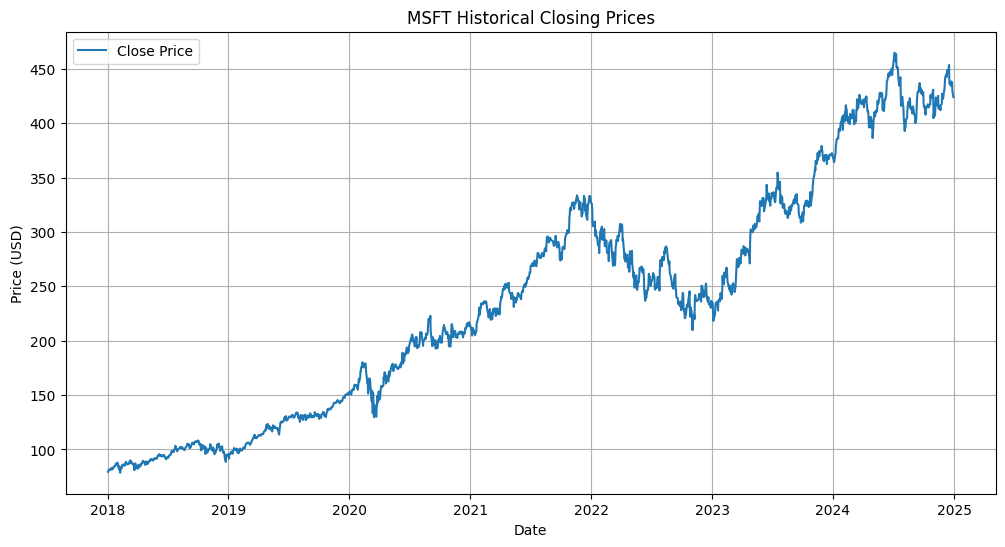

In [22]:
def get_stock_data_yfinance(symbol="MSFT", start="2018-01-01", end="2024-12-31"):
    data = yf.download(symbol, start=start, end=end)
    return data[['Close']]


data = get_stock_data_yfinance()
print(data.head())

plt.figure(figsize=(12, 6))
plt.plot(data, label="Close Price")
plt.title("MSFT Historical Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

window_size=60  
X, y = [], []


# 80% training, 20% testing
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare training data
X_train, y_train = [], []
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i])  # Last 60 days for prediction
    y_train.append(train_data[i])  # Current day's closing price


X_train, y_train = np.array(X_train), np.array(y_train)


X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i])  # Last 10 days for prediction
    y_test.append(test_data[i])  # Current day's closing price

X_test, y_test = np.array(X_test), np.array(y_test)


if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("No data available for training or testing.")



In [23]:
input_shape = (X_train.shape[1], X_train.shape[2])  
    
model = tf.keras.Sequential([
        tf.keras.layers.LSTM(150, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dense(1)
    ])
model.compile(optimizer='adam', loss='mse')
callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1,callbacks=[callback])



test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")

predicted_scaled = model.predict(X_test)


predicted_prices = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

/Users/alperer/Desktop/StockPredictor/myvenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0377 - val_loss: 8.6714e-04
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 6.6130e-04 - val_loss: 0.0015
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 4.8459e-04 - val_loss: 0.0018
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 5.1522e-04 - val_loss: 7.5088e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 4.9217e-04 - val_loss: 0.0016
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 4.7196e-04 - val_loss: 0.0011
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 4.3161e-04 - val_loss: 0.0012
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 4.5156e-04 - val_loss: 9.4050e-04
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 4.9721e-04 - val_loss: 8.3469e-04
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 3.8803e-04 - val_loss: 0.0012
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 4.1071e-04 - val_loss: 9.7330e-04
Ep

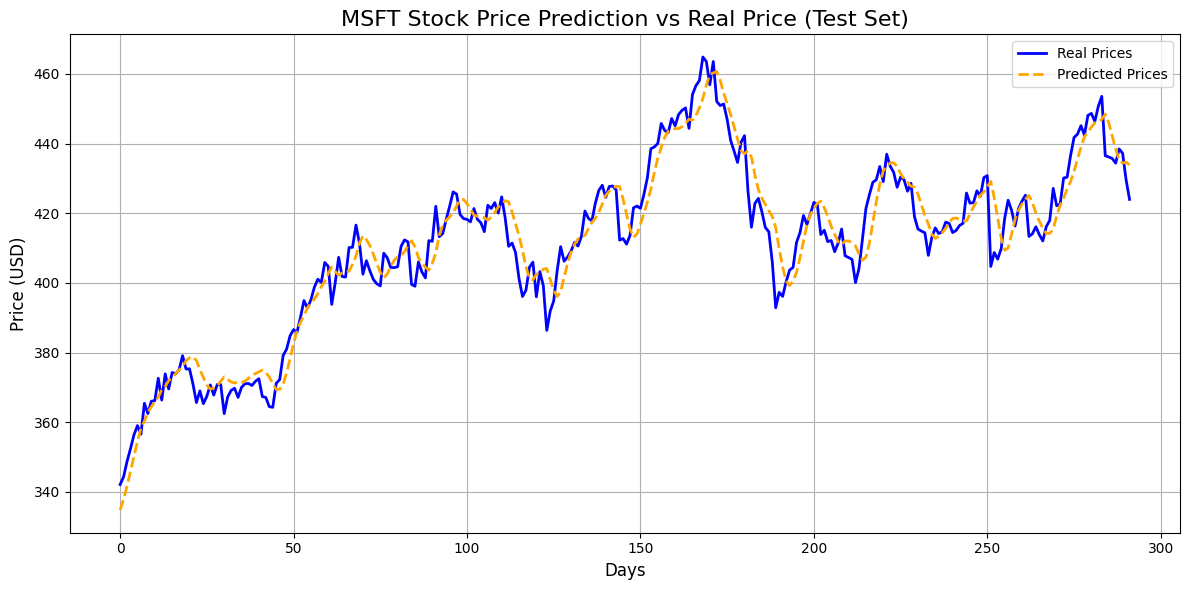

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(real_prices, label='Real Prices', color='blue', linewidth=2)
plt.plot(predicted_prices, label='Predicted Prices', color='orange', linestyle='--', linewidth=2)

plt.title("MSFT Stock Price Prediction vs Real Price (Test Set)", fontsize=16)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


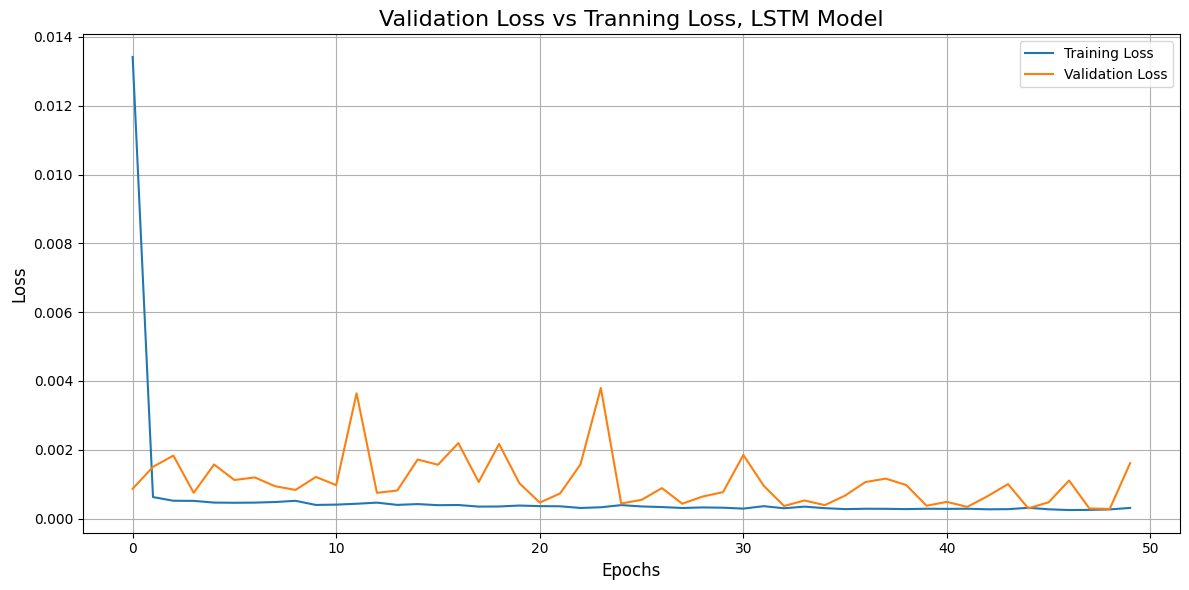

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Validation Loss vs Tranning Loss, LSTM Model", fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Model
model.save('stock_predictor_model.keras')


*End Version 1 Only Closing Price*